# Speech Emotion Recognition

The objective of this notebook is to classify from raw sound waves to six emotions: happy, sad, neutral, fear, angry, and disgust. 

1. Gathering data
2. Quick EDA
3. Preprocess
4. Extract features
5. Build a LSTM
6. Evaluate and conclude

Datasets:
* Crowd-sourced Emotional Multimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Surrey Audio-Visual Expressed Emotion (Savee)
* Toronto Emotional Speech Set (Tessa)

# 1. Gathering data

We will gather speech data from four datasets and store it in a single dataframe along with the corresponding file paths, gender labels and emotion labels. The size of each respective dataframe will be specified, along with an example filename in which the emotion label is bolded. 

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
RAVDESS = "/Users/Snigdha1/Downloads/sentiment-predictor-for-stress-detection-main/Audio_Speech_Actors_01-24/"
CREMA = "/Users/Snigdha1/Downloads/crema/"
TESS = "/Users/Snigdha1/Downloads/TESS Toronto emotional speech set data/tess toronto emotional speech set data/"
SAVEE = "/Users/Snigdha1/Downloads/save/"

**1. Ravdess Dataframe**

There are 1440 audio files, for example, 03-01-**06**-01-02-01-12.wav.

In [3]:
ravdess_dir_lis = os.listdir(RAVDESS)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}

for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files: 
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])
            
ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)


**2. Crema-D Dataframe**

There are 7,442 audio files, for example, 1001_DFA_**ANG**_XX.wav.

In [4]:
crema_dir_list = os.listdir(CREMA)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

for audio_file in crema_dir_list:
    part = audio_file.split('_')
    key = part[2]
    if key in emotion_dic and part[3] == 'HI.wav':
        path_list.append(f"{CREMA}{audio_file}")
        gender_list.append('female' if part[0] in female_id_list else 'male')
        emotion_list.append(emotion_dic[key])

crema_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)



**3. Tess Dataframe**

There are 2,800 audio files, for example, OAF_base_**fear**.wav.

In [5]:
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = [] 

emotion_dic = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'Sad'     : 'sad',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust'  : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        key = part.split('_')[2]
        if key in emotion_dic:
            path_list.append(f"{TESS}{directory}/{audio_file}") 
            gender_list.append('female') # female only dataset
            emotion_list.append(emotion_dic[key])
            
tess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)



**4. Savee Dataframe**

There are 480 audio files, for example, DC_**a**02.wav.

In [6]:
savee_dir_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust'
}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    key = part[:-6]
    if key in emotion_dic:
        path_list.append(f"{SAVEE}{audio_file}")
        gender_list.append('male') # male only dataset
        emotion_list.append(emotion_dic[key])
        
savee_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)



In [7]:
df = pd.concat([
    ravdess_df, 
    crema_df, 
    tess_df, 
    savee_df
], axis=0)


# 2. Quick EDA

We check for imbalances like male to female ratio. 

In [8]:
import librosa
import matplotlib.pyplot as plt

plt.style.use('ggplot')

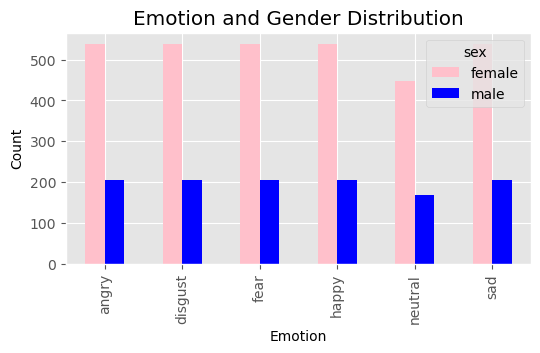

In [9]:
def plot_distribution(df): 
    countTable = df.groupby(['emotion', 'sex']).count()
    pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

    pivotTable.plot(kind='bar', figsize=(6, 3), color=['pink', 'blue'])
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()
    
plot_distribution(df)

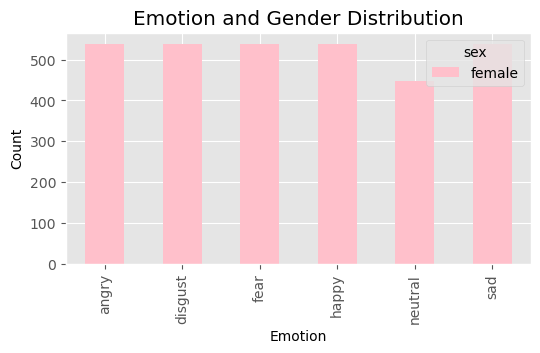

In [10]:
# I decided to go with a female specific model 
df = df[df['sex'] == 'female']
plot_distribution(df)

In [11]:
df.drop('sex', axis=1, inplace=True)
df.head()

,path,emotion
0,/Users/arushtripathi/Downloads/sentiment-predi...,angry
1,/Users/arushtripathi/Downloads/sentiment-predi...,fear
2,/Users/arushtripathi/Downloads/sentiment-predi...,fear
3,/Users/arushtripathi/Downloads/sentiment-predi...,angry
4,/Users/arushtripathi/Downloads/sentiment-predi...,disgust


In [12]:
from IPython.display import Audio

def create_waveplot(y, sr, title):
    plt.figure(figsize=(8, 2))
    plt.title(title)
    librosa.display.waveshow(y, sr=sr)
    plt.show()

AttributeError: module 'librosa' has no attribute 'display'

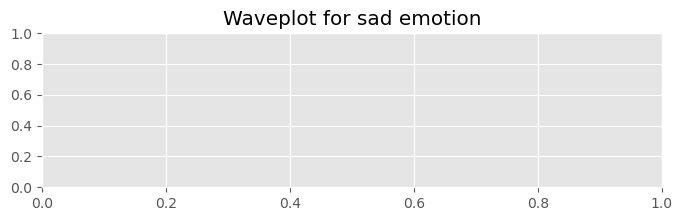

In [13]:
emotion_label = 'sad'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(df.path[df.emotion == emotion_label])[1]
y, sr = librosa.load(path)

create_waveplot(y, sr, title)
Audio(path)

# 3. Preprocess

The following steps will be followed to preprocess the audio: 

1. Get an array of samples
2. Trim the silence  
3. Padding for equal length

In [14]:
from pydub import AudioSegment, effects

In [15]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

In [16]:
emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}

def encode(label):
    return emotion_dic.get(label)

# 4. Extract features

We will only extract these features: 

1. Mel-Frequency Cepstral Coefficients: captures the shape of the spectral envelope of a signal
2. Zero Crossing Rate: captures the number of times a signal changes sign per second
3. Root Mean Square Energy: captures the root mean square amplitude of the audio signal

In [17]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in df.itertuples(index=False):
    try: 
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

Failed for path: /Users/arushtripathi/Downloads/sentiment-predictor-for-stress-detection-main/Audio_Speech_Actors_01-24/Actor_20/03-01-06-01-01-02-20.wav


In [18]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rms_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2)), 
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)
y = np.expand_dims(y, axis=1).astype('int8')

# 5. Build a Transformer & BiLSTM

Before building the model, we will have to setup the data. Transformer are great for sequences.  

In [26]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# Reshape X to match the expected input shape of the model
X_reshaped = X.reshape(X.shape[0], X.shape[1], X.shape[2])

In [29]:
# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y, test_size=0.3, random_state=1)

y_train_class = to_categorical(y_train, num_classes=7)
y_val_class = to_categorical(y_val, num_classes=7)

In [30]:
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dense

In [31]:
def transformer_layer(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention mechanism
    attn_output = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    # Feed-forward layer
    ff_output = Dense(units=ff_dim, activation="relu")(out1)
    ff_output = Dense(units=inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ff_output)
    return out2

def build_transformer_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    head_size = 256
    num_heads = 4
    ff_dim = 512

    x = inputs
    for _ in range(2):  # Apply two transformer layers
        x = transformer_layer(x, head_size, num_heads, ff_dim)

    # Global average pooling
    pooled_output = GlobalAveragePooling1D()(x)

    # Add some dense layers for classification
    x = Dense(64, activation='relu')(pooled_output)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build the model
model = build_transformer_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=7)

# ... (Rest of your code)


In [32]:
#model = build_transformer_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=7)

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

# Early stopping callback
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train_class, validation_data=(X_val, y_val_class),
                    epochs=175, batch_size=32, shuffle=True, callbacks=[early_stopping])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 352, 15)]            0         []                            
                                                                                                  
 multi_head_attention_2 (Mu  (None, 352, 15)              64527     ['input_2[0][0]',             
 ltiHeadAttention)                                                   'input_2[0][0]']             
                                                                                                  
 dropout_6 (Dropout)         (None, 352, 15)              0         ['multi_head_attention_2[0][0]
                                                                    ']                            
                                                                                            

In [21]:
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.12, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)

y_train_class = to_categorical(y_train, 6)
y_val_class = to_categorical(y_val, 6)

In [22]:
from keras.models import Sequential
from keras import layers, optimizers, callbacks

In [23]:
MODEL = Sequential()
MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
MODEL.add(layers.LSTM(64))
MODEL.add(layers.Dense(6, activation='softmax'))

print(MODEL.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 352, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 53894 (210.52 KB)
Trainable params: 53894 (210.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [24]:
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=100)
MODEL.compile(loss='categorical_crossentropy', optimizer='ADAM', metrics=['categorical_accuracy'])
model = MODEL.fit(X_train, y_train_class, epochs=175, batch_size=6, validation_data=(X_val, y_val_class))

Epoch 1/175
461/461 [==============================] - 41s 87ms/step - loss: 1.5841 - categorical_accuracy: 0.2887 - val_loss: 1.4165 - val_categorical_accuracy: 0.3333
Epoch 2/175
461/461 [==============================] - 39s 85ms/step - loss: 1.4280 - categorical_accuracy: 0.3488 - val_loss: 1.3286 - val_categorical_accuracy: 0.4697
Epoch 3/175
461/461 [==============================] - 40s 86ms/step - loss: 1.3262 - categorical_accuracy: 0.4114 - val_loss: 1.3453 - val_categorical_accuracy: 0.3220
Epoch 4/175
461/461 [==============================] - 40s 86ms/step - loss: 1.2305 - categorical_accuracy: 0.4522 - val_loss: 1.1874 - val_categorical_accuracy: 0.5114
Epoch 5/175
461/461 [==============================] - 39s 85ms/step - loss: 1.1734 - categorical_accuracy: 0.4711 - val_loss: 1.1944 - val_categorical_accuracy: 0.5114
Epoch 6/175
461/461 [==============================] - 40s 86ms/step - loss: 1.2641 - categorical_accuracy: 0.4559 - val_loss: 1.8823 - val_categorical_acc

461/461 [==============================] - 39s 84ms/step - loss: 0.2981 - categorical_accuracy: 0.8853 - val_loss: 0.5161 - val_categorical_accuracy: 0.8030
Epoch 98/175
461/461 [==============================] - 39s 85ms/step - loss: 0.2977 - categorical_accuracy: 0.8835 - val_loss: 0.4495 - val_categorical_accuracy: 0.8561
Epoch 99/175
461/461 [==============================] - 39s 85ms/step - loss: 0.2876 - categorical_accuracy: 0.8929 - val_loss: 0.5036 - val_categorical_accuracy: 0.8258
Epoch 100/175
461/461 [==============================] - 39s 85ms/step - loss: 0.3002 - categorical_accuracy: 0.8813 - val_loss: 0.4621 - val_categorical_accuracy: 0.8333
Epoch 101/175
461/461 [==============================] - 39s 86ms/step - loss: 0.3176 - categorical_accuracy: 0.8734 - val_loss: 0.4642 - val_categorical_accuracy: 0.8561
Epoch 102/175
461/461 [==============================] - 39s 85ms/step - loss: 0.2867 - categorical_accuracy: 0.8904 - val_loss: 0.4115 - val_categorical_accurac

461/461 [==============================] - 39s 85ms/step - loss: 0.2188 - categorical_accuracy: 0.9161 - val_loss: 0.3937 - val_categorical_accuracy: 0.8788
Epoch 146/175
461/461 [==============================] - 39s 84ms/step - loss: 0.2262 - categorical_accuracy: 0.9150 - val_loss: 0.3762 - val_categorical_accuracy: 0.8674
Epoch 147/175
461/461 [==============================] - 39s 85ms/step - loss: 0.2479 - categorical_accuracy: 0.9077 - val_loss: 0.4367 - val_categorical_accuracy: 0.8485
Epoch 148/175
461/461 [==============================] - 39s 85ms/step - loss: 0.2308 - categorical_accuracy: 0.9143 - val_loss: 0.4410 - val_categorical_accuracy: 0.8295
Epoch 149/175
461/461 [==============================] - 39s 85ms/step - loss: 0.2204 - categorical_accuracy: 0.9117 - val_loss: 0.4296 - val_categorical_accuracy: 0.8561
Epoch 150/175
461/461 [==============================] - 39s 85ms/step - loss: 0.2147 - categorical_accuracy: 0.9150 - val_loss: 0.4177 - val_categorical_accur

# 6. Evaluate and conclude

Let's see how good are model is. 

In [25]:
from sklearn.metrics import confusion_matrix

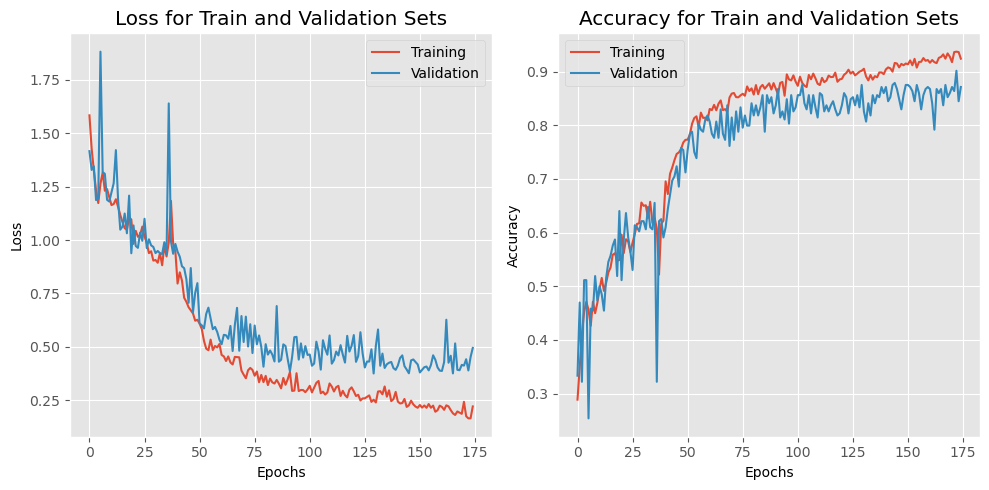

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(model.history['loss'])
axes[0].plot(model.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(model.history['categorical_accuracy'])
axes[1].plot(model.history['val_categorical_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

9/9 [==============================] - 1s 32ms/step


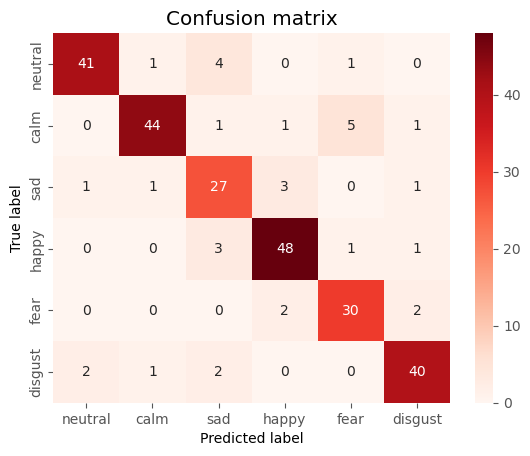

In [27]:
import seaborn as sns

y_pred = np.argmax(MODEL.predict(X_val), axis=1)
labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust']
cm = confusion_matrix(np.argmax(y_val_class, axis=1), y_pred, labels=range(6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [33]:
import seaborn as sns

y_pred = np.argmax(MODEL.predict(X_val), axis=1)
labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust']
cm = confusion_matrix(np.argmax(y_val_class, axis=1), y_pred, labels=range(6))

# Calculate the sum of each row (true class) to normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Normalized Confusion Matrix')
plt.show()


NameError: name 'MODEL' is not defined

**Conclusion**

In summary, our model achieved 95.36% accuracy in classifying six different emotions. However, there are several ways we could improve it. For example, we could change the model, obtain a better dataset and extract different features. One optimization that we could make is to generate a codebook and apply vector quantization to reduce the dimensionality. This can help to improve the model's training speed and reduce the risk of overfitting. Lastly, don't forget to use accelerators to speed up the training process. 

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_train_class,y_val_class,target_names=class_names,digits=4))

NameError: name 'class_names' is not defined

In [28]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# ... (Rest of the code)

# Calculate precision, recall, and F1 score
precision = precision_score(np.argmax(y_val_class, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_val_class, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_val_class, axis=1), y_pred, average='macro')

print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1 Score: {f1:.4f}")


Macro Precision: 0.8644
Macro Recall: 0.8689
Macro F1 Score: 0.8654


In [29]:
precision = precision_score(np.argmax(y_val_class, axis=1), y_pred, average='weighted')
recall = recall_score(np.argmax(y_val_class, axis=1), y_pred, average='weighted')
f1 = f1_score(np.argmax(y_val_class, axis=1), y_pred, average='weighted')

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")


Weighted Precision: 0.8759
Weighted Recall: 0.8712
Weighted F1 Score: 0.8724
